<a href="https://colab.research.google.com/github/raiadi96/Pytorch/blob/master/LogisticRegressionPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch

In [2]:
# MNIST dataset (images and labels)
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor(),
                download = True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


/bin/bash: matplotlib: command not found


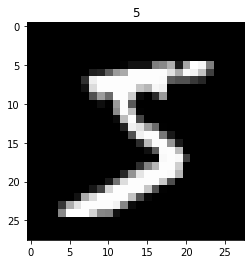

In [3]:
img_tensor,label = dataset[0]
import matplotlib.pyplot as plt
!matplotlib inline
plt.title(label)
plt.imshow(img_tensor[0,:,:],cmap = 'gray')

In [0]:
#creating train set, validation set, test set

import numpy as np

def split_indices(n, val_pct):
  n_val = int(val_pct* n)
  idxs = np.random.permutation(n)
  #return validaition set, train set
  return idxs[:n_val], idxs[n_val:]

In [0]:
val_indices, train_indices = split_indices(len(dataset), val_pct=0.2)
#20 percent of the data will be in validation set, the rest will be in training set

In [0]:
#creating subset sampler and dataLoader instance

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

#set size of each batch
batch_size = 100

train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                      batch_size,
                      sampler = train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                    batch_size,
                    sampler = val_sampler)




In [0]:
#creating our machine learning model

import torch.nn as nn
class MnistModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, num_classes)

  def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
input_size, num_classes = 28*28,10
model = MnistModel()

In [0]:
#adding a loss function

import torch.nn.functional as F

loss_fn = F.cross_entropy

#add optimizer function

learning_rate = 0.000001
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

#add a metric function

def accuracy(l1, l2):
  _, preds = torch.max(l1, dim=1)
  return torch.sum(preds == l2).item()/len(l1)



In [0]:
#create a method for calculating loss for batch

def loss_batch(model, loss_func, xb, yb, opt = None, metric = None):
  #calculate prediction for each batch
  preds = model(xb)
  
  #calculate loss
  loss = loss_fn(preds,yb)

  #optimizing the weights
  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()

  metric_result = None
  
  if metric is not None:
    metric_result = accuracy(preds,yb)
    

  return loss.item(), len(xb), metric_result

In [14]:
#create a training function

def fit(epochs, model, loss_fn, opt, train_dl, valid_dl =None, metric = None):
  loss = None
  for epoch in range(epochs):
    for xb, yb in train_dl:
      loss,_,metric_result = loss_batch(model=model, loss_func= loss_fn, xb = xb, yb = yb, opt = opt, metric = metric)
    print("Epoch: {0} Loss: {1} Accuracy: {2}".format(epoch,loss, metric_result))
    

fit(25,model,loss_fn,optimizer,train_dl,val_dl,accuracy)

Epoch: 0 Loss: 1.1441757678985596 Accuracy: 0.87
Epoch: 1 Loss: 1.1523609161376953 Accuracy: 0.8
Epoch: 2 Loss: 1.2585209608078003 Accuracy: 0.75
Epoch: 3 Loss: 1.309071660041809 Accuracy: 0.82
Epoch: 4 Loss: 1.254440426826477 Accuracy: 0.77
Epoch: 5 Loss: 1.121923565864563 Accuracy: 0.82
Epoch: 6 Loss: 1.2371811866760254 Accuracy: 0.81
Epoch: 7 Loss: 1.1261355876922607 Accuracy: 0.73
Epoch: 8 Loss: 1.2328613996505737 Accuracy: 0.81
Epoch: 9 Loss: 1.2248910665512085 Accuracy: 0.77
Epoch: 10 Loss: 1.3294857740402222 Accuracy: 0.71
Epoch: 11 Loss: 1.192795991897583 Accuracy: 0.82
Epoch: 12 Loss: 1.1952202320098877 Accuracy: 0.79
Epoch: 13 Loss: 1.1967554092407227 Accuracy: 0.79
Epoch: 14 Loss: 1.1972261667251587 Accuracy: 0.82
Epoch: 15 Loss: 1.2177833318710327 Accuracy: 0.75
Epoch: 16 Loss: 1.2164058685302734 Accuracy: 0.79
Epoch: 17 Loss: 1.2837252616882324 Accuracy: 0.8
Epoch: 18 Loss: 1.206121802330017 Accuracy: 0.82
Epoch: 19 Loss: 1.246434211730957 Accuracy: 0.8
Epoch: 20 Loss: 1.2

In [0]:
#validation function

def evaluate(num_epochs, model, loss_fn, valid_dl, metric):
  with torch.no_grad():
      for epoch in range(num_epochs):
        loss_list = []; length_list = []; metric_list = [];
        for xb, yb in valid_dl:
          loss,length,metric = loss_batch(model, loss_fn, xb, yb, None, metric)
          loss_list.append(loss); length_list.append(length); metric_list.append(metric)
        total = np.sum(length_list)
        # Avg. loss across batches 
        avg_loss = np.sum(np.multiply(loss_list, length_list)) / total
        avg_metric = None
        if metric_list is not None:
            # Avg. of metric across batches
            avg_metric = np.sum(np.multiply(metric_list, length_list)) / total
        print("Epoch {0} Loss {1} Accuracy {2}".format(epoch,avg_loss,avg_metric))


In [27]:
evaluate(25, model, loss_fn, val_dl, accuracy)

Epoch 0 Loss 1.21593592663606 Accuracy 0.7994166666666667
Epoch 1 Loss 1.2159359812736512 Accuracy 0.7994166666666667
Epoch 2 Loss 1.2159359435240427 Accuracy 0.7994166666666667
Epoch 3 Loss 1.21593596637249 Accuracy 0.7994166666666667
Epoch 4 Loss 1.215935965379079 Accuracy 0.7994166666666667
Epoch 5 Loss 1.2159359604120255 Accuracy 0.7994166666666667
Epoch 6 Loss 1.215935970346133 Accuracy 0.7994166666666667
Epoch 7 Loss 1.2159359614054361 Accuracy 0.7994166666666667
Epoch 8 Loss 1.2159359683593114 Accuracy 0.7994166666666667
Epoch 9 Loss 1.2159359534581502 Accuracy 0.7994166666666667
Epoch 10 Loss 1.2159359643856684 Accuracy 0.7994166666666667
Epoch 11 Loss 1.215935962398847 Accuracy 0.7994166666666667
Epoch 12 Loss 1.2159359584252039 Accuracy 0.7994166666666667
Epoch 13 Loss 1.215935942530632 Accuracy 0.7994166666666667
Epoch 14 Loss 1.2159359564383825 Accuracy 0.7994166666666667
Epoch 15 Loss 1.2159359773000082 Accuracy 0.7994166666666667
Epoch 16 Loss 1.215935969352722 Accuracy 0

In [0]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

In [31]:
def predict_img(img):
   xb = img.unsqueeze(0)
   yb = model(xb)
   _, preds  = torch.max(yb, dim=1)
   print(preds)
img,label = test_dataset[0]
predict_img(img)
print("Original Label {0}".format(label))

tensor([7])
Original Label 7
